# Machine Translation with Transformer: Full Process and Implementation

In [258]:
import warnings
import argparse
import torch
import math
from trainer.TextTrans import TextTranslator

warnings.filterwarnings('ignore')

In [259]:
def create_args_parser():
    parser = argparse.ArgumentParser(description="Train text translator based on a standard transformer architecture.")
    
    # model parameter setting
    parser.add_argument('--d_model', type=int, default=512, help="dimension for a token")
    parser.add_argument('--n_layers', type=int, default=6, help="number of encoder and decoder layers")
    parser.add_argument('--n_heads', type=int, default=8, help="number of attention heads")
    parser.add_argument('--d_ff', type=int, default=2048, help="dimension of hidden layer in feed forward network")
    parser.add_argument('--max_len', type=int, default=256, help="max length of tokens for a single sentence")
    parser.add_argument('--dropout', type=float, default=0.1, help="dropout probability")

    # optimizer parameter setting
    parser.add_argument('--batch_size', type=int, default=128, help="batch size for training")
    parser.add_argument('--epochs', type=int, default=10, help="number of training epochs")
    parser.add_argument('--warmup', type=int, default=100, help="number of warmup steps for learning rate")
    parser.add_argument('--init_lr', type=float, default=1e-5, help="init learning rate for optimizer")
    parser.add_argument('--factor', type=float, default=0.9, help="learning rate decay factor for optimizer")
    parser.add_argument('--adam_eps', type=float, default=5e-9, help="epsilon value for the Adam optimizer")
    parser.add_argument('--patience', type=int, default=10, help="number of epochs with no improvement in validation loss")
    parser.add_argument('--clip', type=float, default=1.0, help="gradient clipping value")
    parser.add_argument('--weight_decay', type=float, default=5e-4, help="weight decay (L2 regularization) factor")

    # device and dataset setting
    parser.add_argument('--gpu_id', type=int, default=1, help="GPU device ID to use (if 'gpu_id' >= 0). 'gpu_id' is -1 it will use CPU.")
    parser.add_argument('--src_mode', type=str, default='de', help="source language, to encode")
    parser.add_argument('--tgt_mode', type=str, default='en', help="target language, to decode")
    parser.add_argument('--data_path', type=str, default='./data/multi30k/task1/raw/', help="path of training dataset")
    
    return parser

In [260]:
def print_args(args):
    print(">>> Training text translator configs...")
    for arg, value in vars(args).items():
        print(f"{arg}: {value}")

In [261]:
# create training configs
parser = create_args_parser()
args = parser.parse_args(args=[])

print_args(args)

# create transformer-based translator
translator = TextTranslator(args)

>>> Training text translator configs...
d_model: 512
n_layers: 6
n_heads: 8
d_ff: 2048
max_len: 256
dropout: 0.1
batch_size: 128
epochs: 10
warmup: 100
init_lr: 1e-05
factor: 0.9
adam_eps: 5e-09
patience: 10
clip: 1.0
weight_decay: 0.0005
gpu_id: 1
src_mode: de
tgt_mode: en
data_path: ./data/multi30k/task1/raw/
>>> Loading the dataset...
>>> Loading the dataset... Done! <<<
>>> Building the transformer model...
>>> trainable parameters: 65087574 trainable parameters size: 248.28939056396484 MB <<<
>>> Building the transformer model... Done! <<<
>>> Building the optimizer, scheduler and criterion...
>>> Building the optimizer, scheduler and criterion... Done! <<<


## Tokenizer

> The following codes just for exploration about whole processing pipline.

In [262]:
# get out the attributes
DM = translator.data_manager
tokenize_src = DM.tokenize_src
src_vocab = DM.src_vocab

In [263]:
example_word = "I like an apple."
print(f">>> words: {example_word}")
tokens = tokenize_src(example_word)
print(f">>> tokens: {tokens}")

token_ids = []
for token in tokens:
    token_ids.append(src_vocab[token])
print(f">>> token_ids: {token_ids}")

>>> words: I like an apple.
>>> tokens: ['I', 'like', 'an', 'apple', '.']
>>> token_ids: [13329, 0, 61, 0, 16]


In [264]:
# iterate a batch
train_iter = translator.train_iter
one_batch = next(iter(train_iter))
device = translator.device
# source and target languages date
src_batch, tgt_batch = one_batch[0].to(device), one_batch[1].to(device)
print(f">>> src batch shape: {src_batch.shape}")     # batch_size * sentence_len
print(f">>> src batch token_ids:\n{src_batch}")

>>> src batch shape: torch.Size([128, 36])
>>> src batch token_ids:
tensor([[   2,   71,  799,  ...,    1,    1,    1],
        [   2,   24,  250,  ...,    1,    1,    1],
        [   2,   24,  251,  ...,    1,    1,    1],
        ...,
        [   2,   24,   31,  ...,    1,    1,    1],
        [   2,   71,   72,  ...,    1,    1,    1],
        [   2,   24, 8262,  ...,    1,    1,    1]], device='cuda:1')


In [265]:
# predict the last word in target sentence to training model.
tgt_train_batch = tgt_batch[:, :-1]
print(f">>> tgt batch shape: {tgt_batch.shape}")     # batch_size * sentence_len
print(f">>> tgt training batch shape: {tgt_train_batch.shape}")
print(f">>> tgt training batch token_ids:\n{tgt_train_batch}")

>>> tgt batch shape: torch.Size([128, 41])
>>> tgt training batch shape: torch.Size([128, 40])
>>> tgt training batch token_ids:
tensor([[   2,  512,  513,  ...,    1,    1,    1],
        [   2,   26,    5,  ...,    1,    1,    1],
        [   2,   26,    5,  ...,    1,    1,    1],
        ...,
        [   2,   26,   33,  ...,    1,    1,    1],
        [   2,   26,   65,  ...,    1,    1,    1],
        [   2,   26, 1000,  ...,    1,    1,    1]], device='cuda:1')


## Embedding

In [266]:
# load the backbone model
transformer = translator.model

# explore how the mask works 
src_mask = transformer.make_src_mask(src_batch)
print(f">>> src batch mask:\n{src_mask}")

>>> src batch mask:
tensor([[[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        ...,


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]]], device='cuda:1')


In [267]:
# load the src encoder and embedding
encoder = translator.model.encoder
encoder_emb = translator.model.encoder.emb

### Position Embeddings

In [268]:
pe_embeddings = encoder_emb.pos_emb
print(pe_embeddings)

PositionalEncoding(
  (dropout): Dropout(p=0.1, inplace=False)
)


+ Exploration for position embeddings

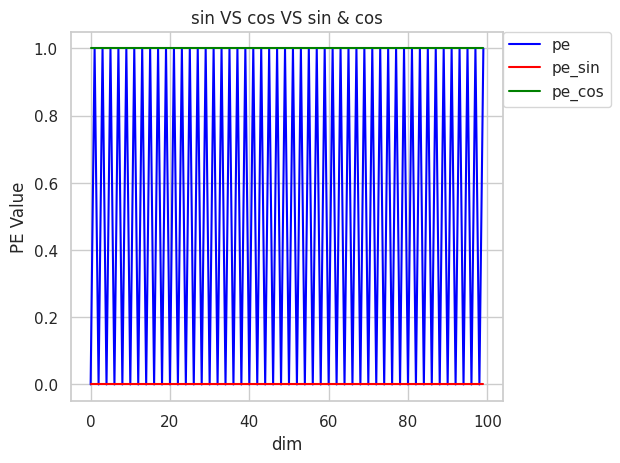

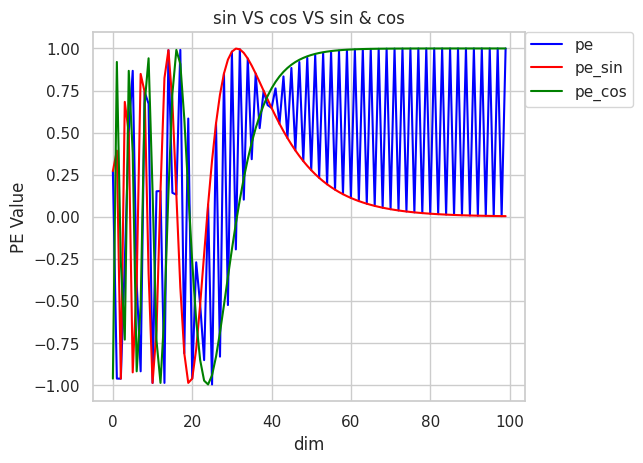

In [269]:
pe_d_model = 100
max_len=500

def div_term(step):
    return torch.exp(
            torch.arange(0, pe_d_model, step) * -(math.log(10000.0) / pe_d_model)
        )

position = torch.arange(0, max_len).unsqueeze(1)

# compare sin, cos, sin & cos signals
pe = torch.zeros(max_len, pe_d_model)
pe_sin = torch.zeros(max_len, pe_d_model)
pe_cos = torch.zeros(max_len, pe_d_model)
pe[:, 0::2] = torch.sin(position * div_term(2))
pe[:, 1::2] = torch.cos(position * div_term(2))
pe_sin = torch.sin(position * div_term(1))
pe_cos = torch.cos(position * div_term(1))

# visulization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

def VisualPE(pos=0):
    x =  torch.arange(0, pe_d_model)

    plt.plot(x, pe[pos, :], label='pe', color='blue')
    plt.plot(x, pe_sin[pos, :], label='pe_sin', color='red')
    plt.plot(x, pe_cos[pos, :], label='pe_cos', color='green')

    plt.title('sin VS cos VS sin & cos')
    plt.xlabel('dim')
    plt.ylabel('PE Value')

    # Adjust legend position to avoid overlapping
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)

    # Adjust the layout to make room for the legend
    plt.subplots_adjust(right=0.8)
    plt.grid(True)

    plt.show()

VisualPE()
VisualPE(28)

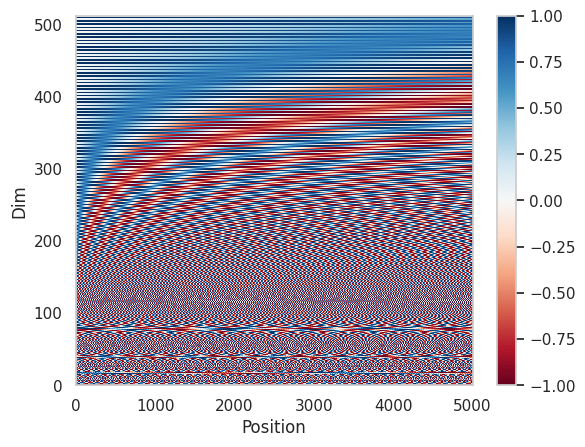

In [270]:
d_model = translator.d_model
max_len=5000

def div_term(step):
    return torch.exp(
            torch.arange(0, d_model, step) * -(math.log(10000.0) / d_model)
        )

position = torch.arange(0, max_len).unsqueeze(1)

# compare sin, cos, sin & cos signals
pe = torch.zeros(max_len, d_model)
pe[:, 0::2] = torch.sin(position * div_term(2))
pe[:, 1::2] = torch.cos(position * div_term(2))

# Plot the dimensions.
plt.pcolormesh(pe.numpy().T, cmap="RdBu")
plt.ylabel("Dim")
plt.xlabel("Position")
plt.colorbar()
plt.show()

In [271]:
# embedding the src batch
src_embeddings = encoder_emb(src_batch)
print(f">>> src batch embeddings shape: {src_embeddings.shape}")     # batch_size * sentence_len * d_model
print(f">>> src batch embeddings:\n{src_embeddings}")

>>> src batch embeddings shape: torch.Size([128, 36, 512])
>>> src batch embeddings:
tensor([[[ 0.0817,  1.1304,  0.0125,  ...,  1.2053, -0.0793,  1.0096],
         [ 1.0059,  0.5784,  0.9023,  ...,  1.0247, -0.0718,  1.1949],
         [ 1.0178, -0.0000,  1.0242,  ...,  0.0000,  0.0862,  1.1627],
         ...,
         [ 0.0000,  0.0785,  0.5068,  ...,  1.0479,  0.0435,  1.2256],
         [ 0.6432, -0.8496,  0.0000,  ...,  1.0479,  0.0437,  1.2256],
         [-0.0000, -0.9109,  0.8485,  ...,  0.0000,  0.0438,  1.2256]],

        [[ 0.0817,  1.1304,  0.0125,  ...,  1.2053, -0.0793,  1.0096],
         [ 0.8445,  0.6528,  0.8430,  ...,  1.0136,  0.0939,  1.1510],
         [ 1.0294, -0.4580,  1.1229,  ...,  1.1255, -0.1016,  1.0737],
         ...,
         [ 1.1663,  0.0785,  0.5068,  ...,  1.0479,  0.0000,  1.2256],
         [ 0.6432, -0.0000,  1.1473,  ...,  1.0479,  0.0437,  1.2256],
         [-0.4205, -0.9109,  0.8485,  ...,  1.0479,  0.0438,  1.2256]],

        [[ 0.0817,  1.1304,  0.

## Encoder
### Self-Attention Head

In [272]:
# a single encoder layer
encoder_layer = encoder.layers[0]
print(encoder_layer)

EncoderLayer(
  (self_attn): MultiHeadedAttention(
    (linears): ModuleList(
      (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): FeedForward(
    (linear_1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (sublayer): ModuleList(
    (0-1): 2 x SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


In [273]:
# calculate self attention: q, k, v
mha = encoder.layers[0].self_attn
print(mha)
w_q = mha.linears[0]
w_k = mha.linears[1]
w_v = mha.linears[2]
w_o = mha.linears[3]

nheads, d_k = translator.n_heads, translator.d_model // translator.n_heads
q, k, v = w_q(src_embeddings), w_k(src_embeddings), w_v(src_embeddings)

# split by n_heads
q = q.view(q.size(0), -1, nheads, d_k).transpose(1, 2)
k = k.view(k.size(0), -1, nheads, d_k).transpose(1, 2)
v = v.view(v.size(0), -1, nheads, d_k).transpose(1, 2)
print(f">>> query shape: {q.shape}")
print(f">>> key shape: {k.shape}")
print(f">>> value shape: {v.shape}")


MultiHeadedAttention(
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
>>> query shape: torch.Size([128, 8, 36, 64])
>>> key shape: torch.Size([128, 8, 36, 64])
>>> value shape: torch.Size([128, 8, 36, 64])


$$
Q = E*W_q\\
K = E*W_k\\
V=E*W_v
$$

In [274]:
# Scaled Dot Product Attention
scores_original = torch.matmul(q, k.transpose(-2, -1))
scores = scores_original / math.sqrt(d_k)
print(f">>> scaled dot product attention score shape: {scores.shape}")
print(f">>> original score first row:\n{scores_original[0, 0, 0, :]}")
print(f">>> scaled score first row:\n{scores[0, 0, 0, :]}")

print(src_mask.shape)
scores = scores.masked_fill(src_mask == 0, -1e9)
print(f">>> masked scaled score first row:\n{scores[0, 0, 0, :]}")

# attention probs
p_attn = scores.softmax(dim=-1)
print(f">>> attention probs shape: {p_attn.shape}")
print(f">>> attention probs first row:\n{p_attn[0, 0, 0, :]}")


>>> scaled dot product attention score shape: torch.Size([128, 8, 36, 36])
>>> original score first row:
tensor([15.2693, 14.3251,  8.3656,  2.5019, -4.6612, -5.7595, -2.6172,  7.1365,
         3.2834, -0.3948, -2.9704,  3.2704, -3.4539,  0.2871, -1.9183,  7.3713,
         4.9042, 14.0485, 13.6349, 11.7177, 16.3299, 11.2532, 12.7470, 13.4291,
        19.2180, 10.7853, 17.4736, 16.0850, 11.1249, 13.2190,  8.1520,  8.7968,
         3.6828,  7.8211, -0.0566,  6.1302], device='cuda:1',
       grad_fn=<SliceBackward0>)
>>> scaled score first row:
tensor([ 1.9087,  1.7906,  1.0457,  0.3127, -0.5827, -0.7199, -0.3272,  0.8921,
         0.4104, -0.0494, -0.3713,  0.4088, -0.4317,  0.0359, -0.2398,  0.9214,
         0.6130,  1.7561,  1.7044,  1.4647,  2.0412,  1.4067,  1.5934,  1.6786,
         2.4023,  1.3482,  2.1842,  2.0106,  1.3906,  1.6524,  1.0190,  1.0996,
         0.4603,  0.9776, -0.0071,  0.7663], device='cuda:1',
       grad_fn=<SliceBackward0>)
torch.Size([128, 1, 1, 36])
>>> maske

In [275]:
# produce the new embeddings which includes the linguistic information about the words relationship in sentence
print(f">>> value shape: {v.shape}")
print(f">>> attention probs shape: {p_attn.shape}")
self_embeddings = torch.matmul(p_attn, v)
print(f">>> self embeddings shape: {self_embeddings.shape}")

>>> value shape: torch.Size([128, 8, 36, 64])
>>> attention probs shape: torch.Size([128, 8, 36, 36])
>>> self embeddings shape: torch.Size([128, 8, 36, 64])


### Multi-Head Attention

In [276]:
# concatenate each self-attention head's output matrix
nbatches = self_embeddings.size(0)
multiheadattention_embeddings = (   
    self_embeddings.transpose(1, 2)
    .contiguous()
    .view(nbatches, -1, nheads * d_k)
)
# apply the output weights
# to learning the contribution for each self attention head
multiheadattention_embeddings = mha.linears[-1](multiheadattention_embeddings)
print(f">>> multiheadattention embeddings shape: {multiheadattention_embeddings.shape}")

>>> multiheadattention embeddings shape: torch.Size([128, 36, 512])


### Residual Connection & Layer Normalization  
> "Add & Norm" is tricky to train from scratch as the gradients diverge. So in the training codes, I adopt the strategy of "Norm & Sublayer & Add". However, to ilusstrate the principles, here I keep same with the original paper, that is "Sublayer & Add & Norm".   

In [277]:
# get the LayerNorm
LayerNorm = encoder.norm

mha_embeddings = LayerNorm(src_embeddings + multiheadattention_embeddings)
print(f">>> encoder embeddings shape: {mha_embeddings.shape}")
print(f">>> multiheadattention embeddings first word:\n{multiheadattention_embeddings[0, 0, :]}")
print(f">>> encoder embeddings first word:\n{mha_embeddings[0, 0, :]}")

>>> encoder embeddings shape: torch.Size([128, 36, 512])
>>> multiheadattention embeddings first word:
tensor([-2.1965e+00, -1.1364e+00,  1.3181e+00,  2.3789e-01,  1.5191e-01,
         9.4496e-02, -5.0148e-01,  1.0992e-01,  6.0189e-01,  2.1246e+00,
         4.6540e-01,  4.8497e-01, -5.9204e-01,  2.1390e+00,  5.7255e-01,
        -6.1360e-01, -6.8346e-01,  1.6798e+00,  1.7832e+00,  8.9797e-01,
        -2.0484e+00, -9.5917e-01,  9.4670e-01,  2.0524e+00, -1.3620e+00,
         1.7792e+00, -2.0537e-01,  5.9434e-01,  5.2264e-04,  1.5323e+00,
         5.0977e-01,  7.4686e-02, -2.0269e+00,  2.7279e+00, -6.6602e-01,
         1.4559e-01,  1.6665e+00,  2.6663e-01,  8.5660e-01, -3.9168e-01,
        -1.6287e+00, -1.9151e-01, -7.4517e-01,  3.7532e-01,  1.4052e+00,
         1.1628e+00, -1.7140e+00, -3.5349e-01,  1.0943e+00,  1.9779e-01,
        -8.4121e-01, -1.0554e+00, -1.3139e+00,  3.9571e-02,  1.6627e+00,
         1.4754e+00,  8.6330e-01, -7.4647e-01, -1.4032e+00, -1.5332e+00,
         2.3364e-01, 

### Feed-Forward Network

In [278]:
ff_mha_embeddings = encoder_layer.feed_forward(mha_embeddings)
print(f">>> FFN embeddings shape: {ff_mha_embeddings.shape}")
print(f">>> FFN embeddings first word:\n{ff_mha_embeddings[0, 0, :]}")

# add & norm
enc_embeddings = LayerNorm(mha_embeddings + ff_mha_embeddings)
print(f">>> Encoder embeddings shape: {enc_embeddings.shape}")
print(f">>> Encoder embeddings first word:\n{enc_embeddings[0, 0, :]}")

>>> FFN embeddings shape: torch.Size([128, 36, 512])
>>> FFN embeddings first word:
tensor([ 2.3249e+00, -4.1440e-02,  7.9750e-01, -1.0755e+00, -2.4640e+00,
        -3.3432e-01,  1.1454e+00,  1.5997e+00,  3.5878e-01,  9.0047e-01,
        -2.1846e+00, -1.0415e+00, -1.6767e+00, -3.5781e-01,  4.8016e-01,
         4.5854e-01, -2.6612e-01,  1.3032e+00, -4.3832e-01,  1.2314e+00,
         9.5146e-01,  1.9026e+00, -1.6151e+00, -1.7984e+00,  1.8650e+00,
         1.5980e+00,  5.7692e-02,  1.3917e-01, -1.5009e+00, -1.9636e+00,
         5.2362e-01,  9.6552e-01, -4.2661e+00, -5.4816e-01,  4.9588e-01,
        -2.8954e-01,  1.4181e+00, -4.4068e-01,  4.0977e-01,  1.9406e+00,
        -1.9980e-01, -1.2061e+00,  1.4121e+00,  1.2926e+00,  2.2731e-02,
        -7.5723e-01, -5.6155e-01, -5.8796e-01, -8.2058e-01,  4.2600e-01,
        -2.6042e-01,  1.1027e-01,  1.9099e+00,  6.7096e-01,  1.6571e+00,
         1.1746e+00,  1.3352e+00, -1.3789e+00,  8.7454e-02, -2.8803e+00,
        -6.0089e-01, -2.8959e-01,  1.115

# Decoder
## Self-Attention Head

In [279]:
# explore how the mask works in the decoder
# first: do padding mask
tgt_pad_idx = transformer.tgt_pad_idx
tgt_pad_mask = (tgt_train_batch != tgt_pad_idx).unsqueeze(1).unsqueeze(3)
print(f">>> target padding mask shape: {tgt_pad_mask.shape}")
print(f">>> target padding mask:\n{src_mask}")

>>> target padding mask shape: torch.Size([128, 1, 40, 1])
>>> target padding mask:
tensor([[[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        ...,


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]],


        [[[ True,  True,  True,  ..., False, False, False]]]], device='cuda:1')


In [280]:
# second: do sub-sentence mask
tgt_len = tgt_train_batch.shape[1]
tgt_ones = torch.ones(tgt_len, tgt_len)   # all elements are 1.
# lower triangular matrix for masking the tokens to be predicted
tgt_sub_mask = torch.tril(tgt_ones).type(torch.ByteTensor).to(device)
print(f">>> target sub mask shape: {tgt_sub_mask.shape}")
print(f">>> target sub mask:\n{tgt_sub_mask}")


>>> target sub mask shape: torch.Size([40, 40])
>>> target sub mask:
tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 1, 0,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 1]], device='cuda:1', dtype=torch.uint8)


In [281]:
# why the shape is [tgt_len, tgt_len]?
tgt_bos_idx = DM.tgt_vocab.get_stoi()['<bos>']
tgt_eos_idx = DM.tgt_vocab.get_stoi()['<eos>']
tgt_pad_idx = DM.tgt_vocab.get_stoi()['<pad>']
print(f">>> target sentence length: {tgt_train_batch.shape[1]}")
print(f">>> target bos token id: {tgt_bos_idx}")
print(f">>> target eos token id: {tgt_eos_idx}")
print(f">>> target pad token id: {tgt_pad_idx}")
print(f">>> target first token id:\n {tgt_train_batch[:, 0]}")
print(f">>> target last token id:\n {tgt_train_batch[:, -1]}")
# only the longest sentence have the eos token at the end.

"""
why the shape is [tgt_len, tgt_len]?
> when produce the 2nd token, must give the 1 at the 1st pose.
> when produce the 3rd token, must give the 1 at the 2nd pose.
> when produce the 4th token, must give the 1 at the 3rd pose.
...
> when produce the tgt_len token, must give the 1 at the tgt_len-1 pose.
> when produce the tgt_len+1 token, must give the 1 at the tgt_len pose.

It will produce the tgt_len target tokens, and each sub mask will be different but with tha same length of tgt_len.
And the padding mask always be fixed and same. That is the shape of 1 * tgt_len.
So it just need to broad the padding mask to keep with sub mask. This will be achieved easily using `&` operation.
"""

>>> target sentence length: 40
>>> target bos token id: 2
>>> target eos token id: 3
>>> target pad token id: 1
>>> target first token id:
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:1')
>>> target last token id:
 tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 15,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,

'\nwhy the shape is [tgt_len, tgt_len]?\n> when produce the 2nd token, must give the 1 at the 1st pose.\n> when produce the 3rd token, must give the 1 at the 2nd pose.\n> when produce the 4th token, must give the 1 at the 3rd pose.\n...\n> when produce the tgt_len token, must give the 1 at the tgt_len-1 pose.\n> when produce the tgt_len+1 token, must give the 1 at the tgt_len pose.\n\nIt will produce the tgt_len target tokens, and each sub mask will be different but with tha same length of tgt_len.\nAnd the padding mask always be fixed and same. That is the shape of 1 * tgt_len.\nSo it just need to broad the padding mask to keep with sub mask. This will be achieved easily using `&` operation.\n'

In [282]:
# third: combine the two masks
tgt_mask = tgt_pad_mask & tgt_sub_mask
print(f">>> target sentence mask shape:\n{tgt_mask.shape}")
print(f">>> target sentence mask:\n{tgt_mask}")

>>> target sentence mask shape:
torch.Size([128, 1, 40, 40])
>>> target sentence mask:
tensor([[[[1, 0, 0,  ..., 0, 0, 0],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 0, 0,  ..., 0, 0, 0],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 0, 0,  ..., 0, 0, 0],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[1, 0, 0,  ..., 0, 0, 0],
          [1, 1, 0,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]

In [283]:
# load the tgt decoder and embedding
decoder = translator.model.decoder
decoder_emb = translator.model.decoder.emb

# embedding the tgt batch
tgt_embeddings = decoder_emb(tgt_train_batch)
print(f">>> tgt batch embeddings shape: {tgt_embeddings.shape}")     # batch_size * sentence_len * d_model
print(f">>> tgt batch embeddings:\n{tgt_embeddings}")

>>> tgt batch embeddings shape: torch.Size([128, 40, 512])
>>> tgt batch embeddings:
tensor([[[-0.0796,  1.2236,  0.1201,  ...,  1.0141,  0.0943,  1.1771],
         [ 0.0000,  0.5679,  0.9707,  ...,  1.2093,  0.0137,  0.0000],
         [ 1.0793, -0.0000,  0.9488,  ...,  1.0683,  0.0134,  1.2201],
         ...,
         [-0.5976,  0.9030, -0.8917,  ...,  1.2098,  0.1053,  0.0000],
         [ 0.4468,  1.1137, -0.0000,  ...,  1.2098,  0.0000,  1.1629],
         [ 1.1884,  0.0000,  0.0297,  ...,  1.2098,  0.1055,  1.1629]],

        [[-0.0796,  1.2236,  0.0000,  ...,  1.0141,  0.0943,  1.1771],
         [ 0.9742,  0.5340,  0.9071,  ...,  1.2215,  0.0345,  1.1107],
         [ 0.9173, -0.3477,  1.0712,  ...,  1.0211,  0.1027,  1.2138],
         ...,
         [-0.5976,  0.9030, -0.8917,  ...,  1.2098,  0.1053,  1.1629],
         [ 0.4468,  1.1137, -0.8438,  ...,  1.2098,  0.1054,  1.1629],
         [ 1.1884,  0.3488,  0.0297,  ...,  1.2098,  0.1055,  1.1629]],

        [[-0.0796,  1.2236,  0.

In [284]:
# a single decoder layer
decoder_layer = decoder.layers[0]
print(decoder_layer)

DecoderLayer(
  (self_attn): MultiHeadedAttention(
    (linears): ModuleList(
      (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (cross_attn): MultiHeadedAttention(
    (linears): ModuleList(
      (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (feed_forward): FeedForward(
    (linear_1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear_2): Linear(in_features=2048, out_features=512, bias=True)
  )
  (sublayer): ModuleList(
    (0-2): 3 x SublayerConnection(
      (norm): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)


In [285]:
# calculate self attention: q, k, v
mha = decoder.layers[0].self_attn
print(mha)
w_q = mha.linears[0]
w_k = mha.linears[1]
w_v = mha.linears[2]
w_o = mha.linears[3]

nheads, d_k = translator.n_heads, translator.d_model // translator.n_heads
q, k, v = w_q(tgt_embeddings), w_k(tgt_embeddings), w_v(tgt_embeddings)

# split by n_heads
q = q.view(q.size(0), -1, nheads, d_k).transpose(1, 2)
k = k.view(k.size(0), -1, nheads, d_k).transpose(1, 2)
v = v.view(v.size(0), -1, nheads, d_k).transpose(1, 2)
print(f">>> query shape: {q.shape}")
print(f">>> key shape: {k.shape}")
print(f">>> value shape: {v.shape}")

MultiHeadedAttention(
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
>>> query shape: torch.Size([128, 8, 40, 64])
>>> key shape: torch.Size([128, 8, 40, 64])
>>> value shape: torch.Size([128, 8, 40, 64])


In [286]:
# Scaled Dot Product Attention
scores_original = torch.matmul(q, k.transpose(-2, -1))
scores = scores_original / math.sqrt(d_k)
print(f">>> scaled dot product attention score shape: {scores.shape}")
print(f">>> original score first row:\n{scores_original[0, 0, 0, :]}")
print(f">>> scaled score first row:\n{scores[0, 0, 0, :]}")

print(tgt_mask.shape)

# give the masked tokens a very small number (negative),
# so they will get a probability very close to zero after softmax. 
scores = scores.masked_fill(tgt_mask == 0, -1e9)
print(f">>> masked scaled score first row:\n{scores[0, 0, 0, :]}")

# attention probs
p_attn = scores.softmax(dim=-1)
print(f">>> attention probs shape: {p_attn.shape}")
print(f">>> attention probs first row:\n{p_attn[0, 0, 0, :]}")


>>> scaled dot product attention score shape: torch.Size([128, 8, 40, 40])
>>> original score first row:
tensor([ -3.3039,  -2.9065,  -5.7729,  -3.9479,   0.4841,  -0.2729,  -1.9868,
         -4.7861,  -3.5364,  -7.9060, -10.1800,  -7.7883,  -8.5280, -12.8392,
         -7.0603, -12.4493, -10.4504, -14.4971, -15.5950, -14.3696, -11.4332,
        -10.1233,  -3.2209,  -8.4629,  -3.4360, -15.5682,  -8.2396,  -7.5021,
        -10.9924,  -4.4636,  -6.5232,  -5.2175, -14.3775,  -6.8512,  -4.4228,
         -9.1468, -16.5821, -16.7918, -16.2145, -16.0182], device='cuda:1',
       grad_fn=<SliceBackward0>)
>>> scaled score first row:
tensor([-0.4130, -0.3633, -0.7216, -0.4935,  0.0605, -0.0341, -0.2484, -0.5983,
        -0.4420, -0.9883, -1.2725, -0.9735, -1.0660, -1.6049, -0.8825, -1.5562,
        -1.3063, -1.8121, -1.9494, -1.7962, -1.4292, -1.2654, -0.4026, -1.0579,
        -0.4295, -1.9460, -1.0299, -0.9378, -1.3740, -0.5579, -0.8154, -0.6522,
        -1.7972, -0.8564, -0.5528, -1.1434, -2.0

In [287]:
# produce the new embeddings which includes the linguistic information about the words relationship in sentence
print(f">>> value shape: {v.shape}")
print(f">>> attention probs shape: {p_attn.shape}")
self_embeddings = torch.matmul(p_attn, v)
print(f">>> self embeddings shape: {self_embeddings.shape}")

>>> value shape: torch.Size([128, 8, 40, 64])
>>> attention probs shape: torch.Size([128, 8, 40, 40])
>>> self embeddings shape: torch.Size([128, 8, 40, 64])


### Multi-Head Attention

In [288]:
# concatenate each self-attention head's output matrix
nbatches = self_embeddings.size(0)
multiheadattention_embeddings = (   
    self_embeddings.transpose(1, 2)
    .contiguous()
    .view(nbatches, -1, nheads * d_k)
)
# apply the output weights
# to learning the contribution for each self attention head
multiheadattention_embeddings = mha.linears[-1](multiheadattention_embeddings)
print(f">>> multiheadattention embeddings shape: {multiheadattention_embeddings.shape}")

>>> multiheadattention embeddings shape: torch.Size([128, 40, 512])


### Residual Connection & Layer Normalization

In [289]:
# get the LayerNorm
LayerNorm = decoder.norm

mha_embeddings = LayerNorm(tgt_embeddings + multiheadattention_embeddings)
print(f">>> decoder embeddings shape: {mha_embeddings.shape}")
print(f">>> multiheadattention embeddings first word:\n{multiheadattention_embeddings[0, 0, :]}")
print(f">>> decoder embeddings first word:\n{mha_embeddings[0, 0, :]}")

>>> decoder embeddings shape: torch.Size([128, 40, 512])
>>> multiheadattention embeddings first word:
tensor([ 1.2458, -0.1759,  0.9732,  1.4783, -1.4708, -0.4592, -2.8110, -2.0367,
         0.7939, -0.2393,  0.8129, -1.7637, -5.2287, -1.6799, -0.8028,  0.5757,
        -0.1110,  0.8356,  0.7028, -0.9918,  1.8760, -2.3799,  0.5352, -0.1891,
         0.4592, -1.9978, -0.8101, -0.2019, -1.3493, -0.7580,  1.8908, -1.2691,
        -0.2078,  1.1306,  1.1999,  1.1728,  1.6274, -1.4785, -0.4741,  1.2297,
         0.3189,  0.5017, -0.5777, -0.9940, -0.3305,  0.2972, -0.2828,  0.1279,
        -1.4005,  3.0326,  1.0798,  1.0006,  0.8769, -0.6852,  1.0030,  0.4322,
         2.7457, -3.1769,  2.0737,  2.9950,  0.8670, -0.3383,  1.8640,  1.1810,
         2.0981, -1.3254,  0.2569,  2.0199,  1.0790,  2.4248, -0.8162, -1.1955,
         0.6655, -1.9282,  2.7715, -0.0394,  0.4443,  0.4373, -0.9348,  1.0479,
         0.5884, -3.0731, -3.0818, -2.7513, -0.5834, -1.3935, -0.9047, -1.8215,
         1.3733, 

## Cross-Attention Head
> Note: There it's not the cross-attention between different modalities, not strictly speaking. Owing to the combination between encoder's output information and decoder's self-attention, I think it just crossed the source and target attention to merge them. So this attention module includes the both information, that's the meaning of cross. 

In [290]:
# calculate corss attention: q, k, v
cross_mha = decoder.layers[0].cross_attn
print(cross_mha)
w_q = cross_mha.linears[0]
w_k = cross_mha.linears[1]
w_v = cross_mha.linears[2]
w_o = cross_mha.linears[3]

nheads, d_k = translator.n_heads, translator.d_model // translator.n_heads

# q: decoder attention, k: encoder attention, v: encoder attention
q, k, v = w_q(mha_embeddings), w_k(enc_embeddings), w_v(enc_embeddings)

# split by n_heads
q = q.view(q.size(0), -1, nheads, d_k).transpose(1, 2)
k = k.view(k.size(0), -1, nheads, d_k).transpose(1, 2)
v = v.view(v.size(0), -1, nheads, d_k).transpose(1, 2)
print(f">>> query shape: {q.shape}")
print(f">>> key shape: {k.shape}")
print(f">>> value shape: {v.shape}")

MultiHeadedAttention(
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
)
>>> query shape: torch.Size([128, 8, 40, 64])
>>> key shape: torch.Size([128, 8, 36, 64])
>>> value shape: torch.Size([128, 8, 36, 64])


+ Function: Find the closest location between produced words and the source words
+ Purpose: For producing next word corresponding to the source words.

In [291]:
# Scaled Dot Product Attention
scores_original = torch.matmul(q, k.transpose(-2, -1))
scores = scores_original / math.sqrt(d_k)
print(f">>> scaled dot product attention score shape: {scores.shape}")
print(f">>> original score first row:\n{scores_original[0, 0, 0, :]}")
print(f">>> scaled score first row:\n{scores[0, 0, 0, :]}")

print(src_mask.shape)

# give the masked tokens a very small number (negative),
# so they will get a probability very close to zero after softmax. 
scores = scores.masked_fill(src_mask == 0, -1e9)
print(f">>> masked scaled score first row:\n{scores[0, 0, 0, :]}")

# attention probs
p_attn = scores.softmax(dim=-1)
print(f">>> attention probs shape: {p_attn.shape}")
print(f">>> attention probs first row:\n{p_attn[0, 0, 0, :]}")


>>> scaled dot product attention score shape: torch.Size([128, 8, 40, 36])
>>> original score first row:
tensor([-15.8273, -14.2780, -12.5907, -14.6567, -10.6238,  -2.2347,  -6.2027,
         -1.8726, -14.9201,  -3.3064,   0.8008,  -2.4677,  -4.6011,  -4.4539,
         -8.1567,  -6.9218,  -9.6909, -13.5797, -17.5991, -18.0182, -14.8737,
        -12.0023, -17.2155, -19.7964, -17.3151, -22.7803, -17.6642, -18.9402,
        -14.1432, -12.4944, -22.8650,  -8.2511, -12.6202,  -9.7183, -10.7126,
        -14.0476], device='cuda:1', grad_fn=<SliceBackward0>)
>>> scaled score first row:
tensor([-1.9784, -1.7847, -1.5738, -1.8321, -1.3280, -0.2793, -0.7753, -0.2341,
        -1.8650, -0.4133,  0.1001, -0.3085, -0.5751, -0.5567, -1.0196, -0.8652,
        -1.2114, -1.6975, -2.1999, -2.2523, -1.8592, -1.5003, -2.1519, -2.4745,
        -2.1644, -2.8475, -2.2080, -2.3675, -1.7679, -1.5618, -2.8581, -1.0314,
        -1.5775, -1.2148, -1.3391, -1.7560], device='cuda:1',
       grad_fn=<SliceBackward0>)


"I have the following words already, please give me the next word."

This is the direct interpration for the cross-attention.

In [292]:
# produce the new embeddings which includes the linguistic information about the words relationship in sentence
print(f">>> value shape: {v.shape}")
print(f">>> attention probs shape: {p_attn.shape}")
cross_embeddings = torch.matmul(p_attn, v)
print(f">>> cross embeddings shape: {cross_embeddings.shape}")

>>> value shape: torch.Size([128, 8, 36, 64])
>>> attention probs shape: torch.Size([128, 8, 40, 36])
>>> cross embeddings shape: torch.Size([128, 8, 40, 64])


### Multi-Head Attention

In [293]:
# concatenate each cross-attention head's output matrix
nbatches = cross_embeddings.size(0)
cross_mha_embeddings = (   
    cross_embeddings.transpose(1, 2)
    .contiguous()
    .view(nbatches, -1, nheads * d_k)
)
# apply the output weights
# to learning the contribution for each self attention head
cross_mha_embeddings = cross_mha.linears[-1](cross_mha_embeddings)
print(f">>> cross multiheadattention embeddings shape: {cross_mha_embeddings.shape}")

>>> cross multiheadattention embeddings shape: torch.Size([128, 40, 512])


### Residual Connection & Layer Normalization

In [294]:
# get the LayerNorm
LayerNorm = decoder.norm

endec_embeddings = LayerNorm(mha_embeddings + cross_mha_embeddings)
print(f">>> encoder-decoder embeddings shape: {endec_embeddings.shape}")
print(f">>> cross mha embeddings first word:\n{cross_mha_embeddings[0, 0, :]}")
print(f">>> encoder-decoder embeddings first word:\n{endec_embeddings[0, 0, :]}")

>>> encoder-decoder embeddings shape: torch.Size([128, 40, 512])


>>> cross mha embeddings first word:
tensor([ 1.0130, -0.2643,  0.8407,  1.4008, -1.6968,  1.2474, -3.5262,  0.3331,
        -3.6604,  0.3651, -0.4913,  1.5814,  0.8265,  1.0170, -2.8616,  1.5916,
         0.7295, -3.1747,  2.1421, -1.1558,  0.8905,  0.1425, -1.5815, -1.2563,
         1.6400, -0.8381, -1.0658, -3.2292,  0.8385, -0.0594,  0.3909,  0.5356,
        -0.5071, -7.0752, -1.4240,  0.1395,  0.8318, -1.3481, -1.8927, -0.8975,
        -0.1859, -2.0196,  0.2585,  1.9095,  3.3616,  2.8357, -0.8707,  2.3822,
         1.3641,  1.5637, -1.1253, -0.9693,  3.6050, -1.0869,  1.3293,  2.1277,
        -0.5629,  0.0602,  0.7181, -1.4762,  2.5367, -3.2506,  2.0795, -2.7514,
        -0.4572,  2.6186, -3.4746,  0.4859, -2.0539, -1.5673, -1.2295,  1.7259,
         2.7013, -2.3883, -0.5286,  0.0432, -0.3493,  1.1767, -4.5836,  1.9060,
        -0.3714,  0.4570, -0.7267, -1.2121,  4.3307, -1.6621, -0.7235,  0.6172,
        -1.3949,  2.0270,  1.0013,  1.6529,  1.0337,  0.7766, -2.2644,  0.5167,
   

### Feed-Forward Network

In [295]:
ff_endec_embeddings = decoder_layer.feed_forward(endec_embeddings)
print(f">>> FFN encoder-decoder embeddings shape: {ff_endec_embeddings.shape}")
print(f">>> FFN encoder-decoder embeddings first word:\n{ff_endec_embeddings[0, 0, :]}")

# add & norm
endec_embeddings = LayerNorm(endec_embeddings + ff_endec_embeddings)
print(f">>> Encoder-Decoder embeddings shape: {endec_embeddings.shape}")
print(f">>> Encoder-Decoder embeddings first word:\n{endec_embeddings[0, 0, :]}")

>>> FFN encoder-decoder embeddings shape: torch.Size([128, 40, 512])
>>> FFN encoder-decoder embeddings first word:
tensor([-0.9455, -1.7356,  0.4521, -0.2845, -0.3226, -0.3403,  0.6252,  2.4632,
        -0.9213, -0.0820,  1.8233,  1.9259, -1.4306, -2.2642,  0.0074,  0.9189,
        -2.2604,  1.5556,  1.6307,  2.4401,  2.5745, -2.1683,  0.7148,  1.6461,
         2.6169, -0.7729,  0.6673,  0.6132, -2.1578,  0.1139,  0.1726, -0.9457,
         0.6493, -1.8670,  1.2593, -0.7907,  0.7831,  1.6870,  1.0389,  1.4988,
        -0.0101,  0.8461, -0.2280,  1.2990,  0.4875,  0.7945,  0.3198, -1.8363,
        -1.0271,  0.1711, -1.0537, -1.0635, -0.6251, -1.1113,  2.3187, -1.0575,
        -1.1423,  0.7493, -2.3628, -0.2689,  1.4665,  2.3082, -1.3616,  1.8033,
         2.1198,  0.0360, -0.3942,  2.1236, -3.2708, -1.5949, -2.3697,  0.0262,
        -0.1909, -0.9060, -1.4321, -0.9912,  0.1400,  1.3700,  2.2368,  0.6600,
         0.5638, -2.1585, -0.2107,  0.3026, -0.7577, -1.8030, -1.7258, -0.1798,
    

## Generator
> Final linear layer for producing the next token.

In [296]:
generator = transformer.generator
print(f">>> next token generator: {generator}")

>>> next token generator: Generator(
  (proj): Linear(in_features=512, out_features=10838, bias=True)
)


In [297]:
# first project the encoder-decoder embeddings
logits = generator.proj(endec_embeddings)
print(f">>> logits shape: {logits.shape}")

# second transform through soft_max
from torch.nn.functional import log_softmax
probs = log_softmax(logits, dim=-1)
print(f">>> probs shape: {probs.shape}")

>>> logits shape: torch.Size([128, 40, 10838])
>>> probs shape: torch.Size([128, 40, 10838])


## Calculate Learning Loss

In [298]:
probs_reshape = probs.contiguous().view(-1, probs.shape[-1])
# original target batch
print(f">>> original target batch shape: {tgt_batch.shape}")
# predict the probs form 2nd to tgt_len tokens
print(f">>> predict probs batch shape: {probs_reshape.shape}")

# each target token goal: only use the 2 to tgt_len tokens
token_goals = tgt_batch[:, 1:].contiguous().view(-1)
print(f">>> token goals batch shape: {token_goals.shape}")

>>> original target batch shape: torch.Size([128, 41])
>>> predict probs batch shape: torch.Size([5120, 10838])
>>> token goals batch shape: torch.Size([5120])


In [299]:
# CE loss acting as s classifier
predict_loss = translator.criterion(probs_reshape, token_goals)
print(f">>> predict token loss: {predict_loss:.2f}")

>>> predict token loss: 10.46


## Compare target words with predict words
> The results can be just as reference, not used to evaluate the model. Because we just explore the pipline not truly training it.

In [300]:
from trainer.tools import idx_to_word

predict_tokens = probs.argmax(dim=-1)
print(f">>> predict tokens batch shape: {predict_tokens.shape}")
for b in range(5):
    tgt_words = idx_to_word(tgt_train_batch[b], DM.tgt_vocab)
    predict_words = idx_to_word(predict_tokens[b], DM.tgt_vocab)
    print(f">>> target words:\n{tgt_words}>>> predict words:\n{predict_words}")

>>> predict tokens batch shape: torch.Size([128, 40])


>>> target words:
An older woman with a cane is walking with a sign around her neck . 
>>> predict words:
snowbank sash snowbank snowbank adjustment snowbank operation snowbank operation operation hitch operation operation notes twirling cabinets cabinets twirling strumming Funny operation operation twirling operation breakdancing operation strumming strumming twirling breakdancing adjustment notes operation Funny Funny twirling MMA cabinets enforcement strumming
>>> target words:
A young boy with blond - hair smiling while posing on a tree branch . 
>>> predict words:
twirling operation breakdancing pops notes hitch notes operation operation operation twirling operation breakdancing breakdancing twirling breakdancing notes concepts organism operation breakdancing twirling adjustment operation operation strumming adjustment adjustment breakdancing strumming breakdancing notes notes notes ornament notes notes ornament notes cabinets
>>> target words:
A young boy and girl are hiding in t